In [1]:
import  random
import numpy as np
import time
import pickle

In [2]:
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants

In [19]:
X_subTr = np.loadtxt('D:\\bro\\Analysis\\mSANN\\cd\\XTr.dat')
y_subCdTr = (np.loadtxt('D:\\bro\\Analysis\\mSANN\\cd\\yTr.dat')).reshape((-1,1))

In [20]:
X_subTr.shape

(42039, 16)

In [21]:
y_subCdTr.shape

(42039, 1)

In [30]:
import pandas as pd
dep=pd.read_csv("D:\\bro\\Analysis\\mSANN\\cd\\XTr.dat",sep='\s+',names=[str(i) for i in range(0,16)])
indep=pd.read_csv("D:\\bro\\Analysis\\mSANN\\cd\\yTr.dat",sep='\s+',names=['target'])
dep.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000
mean,-0.248356,-0.004138,-0.002063,-0.000411,-0.000244,0.000038,0.000032,-0.955813,0.001766,-0.002187,-0.001022,-0.000561,0.000159,-0.000144,0.451158,2.030716
std,0.143186,0.017691,0.006818,0.002907,0.002112,0.001049,0.000804,0.314483,0.040846,0.019695,0.008817,0.004493,0.002566,0.001893,0.086088,1.827649
min,-0.497415,-0.136435,-0.038454,-0.014248,-0.008885,-0.006627,-0.003817,-1.499592,-0.227272,-0.101638,-0.059503,-0.036878,-0.014407,-0.009225,0.300213,-1.198834
25%,-0.371456,-0.015947,-0.006744,-0.002432,-0.001656,-0.000697,-0.000500,-1.227219,-0.023441,-0.016485,-0.007183,-0.003799,-0.001689,-0.001545,0.377545,0.466435
50%,-0.247950,-0.003717,-0.002128,-0.000507,-0.000342,-0.000014,0.000057,-0.956767,0.004604,-0.004193,-0.001187,-0.000539,0.000047,-0.000227,0.452744,2.031259
75%,-0.125162,0.007631,0.002595,0.001448,0.001014,0.000713,0.000558,-0.686958,0.030148,0.010435,0.004850,0.002828,0.001818,0.001189,0.524987,3.600611
max,0.000064,0.065562,0.038597,0.019244,0.012764,0.005687,0.007473,-0.403419,0.300085,0.097836,0.037676,0.017639,0.022246,0.008829,0.599638,5.194131


In [31]:
indep.describe()

,target
count,42039.000000
mean,0.011824
std,0.003658
min,0.007400
25%,0.009818
50%,0.011084
75%,0.012735
max,0.070915


<AxesSubplot:xlabel='target'>

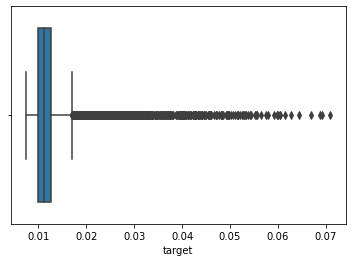

In [24]:
## analysis
import seaborn as sns
sns.boxplot(x=indep['target'])

<AxesSubplot:xlabel='target'>

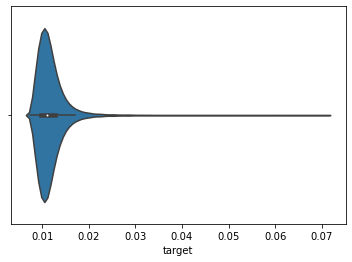

In [25]:
sns.violinplot(x=indep['target'])

<AxesSubplot:xlabel='target', ylabel='Density'>

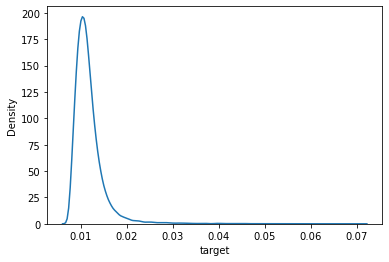

In [26]:
sns.kdeplot(x=indep['target'])

<AxesSubplot:xlabel='15', ylabel='target'>

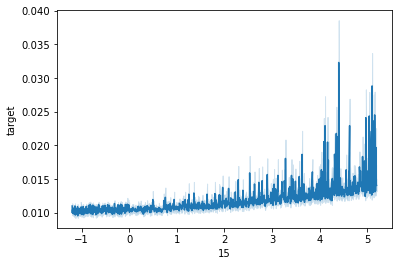

In [32]:
sns.lineplot(x=dep['15'], y=indep['target'])

In [33]:
dep['15'].shape

(42039,)

In [34]:
indep['target'].shape

(42039,)

<AxesSubplot:xlabel='15', ylabel='target'>

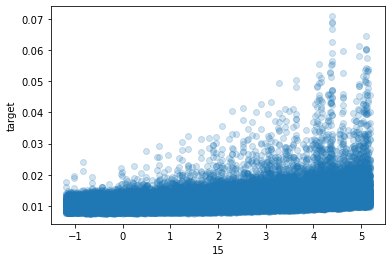

In [35]:
sns.regplot(x =dep['15'], y=indep['target'], fit_reg = False, scatter_kws={"alpha": 0.2})

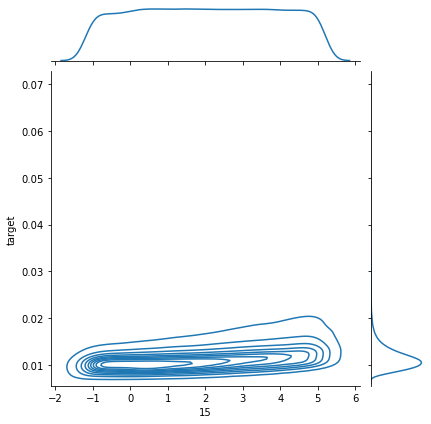

In [36]:
sns.jointplot(x =dep['15'], y=indep['target'], kind = 'kde')

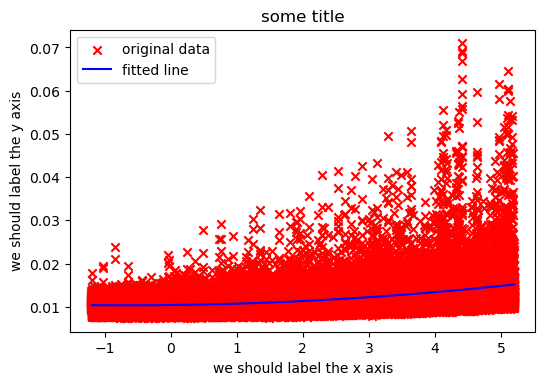

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


# this is the function we want to fit
def func(x, a, b, c):
    return a*x*x + b*x + c
x_values=dep['15']
y_values=indep['target']
fig, ax = plt.subplots()
fig.set_dpi(100.0)

ax.scatter(x_values, y_values, c="red", marker="x", label="original data")

# non-linear least squares to fit func to data
p_opt, p_cov = curve_fit(func, x_values, y_values)

# these are the fitted values a, b, c
a, b, c = p_opt

# produce 100 values in the range we want to cover along x
x_fit = np.linspace(min(x_values), max(x_values), 100)

# compute fitted y values
y_fit = [func(x, a, b, c) for x in x_fit]

ax.plot(x_fit, y_fit, c="blue", label="fitted line")

ax.set_xlabel("we should label the x axis")
ax.set_ylabel("we should label the y axis")
ax.set_title("some title")
ax.legend()

In [38]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor  
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
max_features=0.5, n_jobs=-1, oob_score=True)

In [39]:
m.fit(dep, indep)  


C:\Users\kiran.franklin\AppData\Local\Temp\ipykernel_18696\322511730.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(dep, indep)


RandomForestRegressor(max_features=0.5, min_samples_leaf=3, n_estimators=40,
                      n_jobs=-1, oob_score=True)

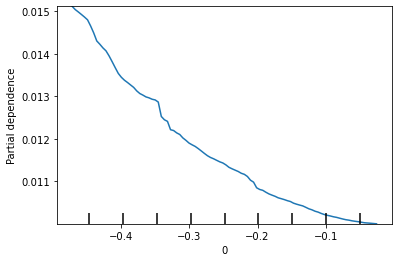

In [46]:
disp1 = PartialDependenceDisplay.from_estimator(m, dep,
...                                                 [0])

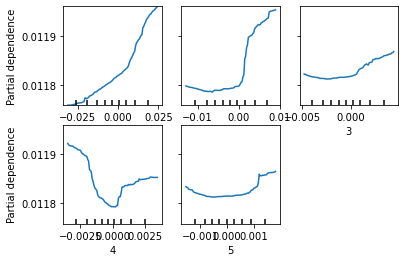

In [42]:
disp1 = PartialDependenceDisplay.from_estimator(m, dep,
...                                                 [1,2,3,4,5])

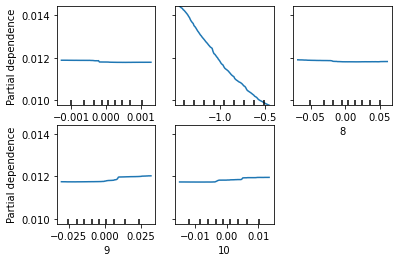

In [43]:
disp1 = PartialDependenceDisplay.from_estimator(m, dep,
...                                                 [6,7,8,9,10])

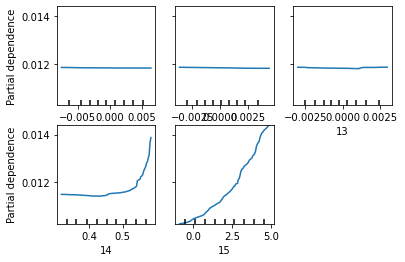

In [45]:
disp1 = PartialDependenceDisplay.from_estimator(m, dep,
...                                                 [11,12,13,14,15,])

In [47]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 90, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [48]:
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(dep, indep)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\kiran.franklin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 18, 26, 34, 42, 50,
                                                      58, 66, 74, 82, 90,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 233, 266, 300,
                                                         333, 366, 400, 433,
                                                         466, 500]},
                   random_state=42, verbose=2)

In [49]:
rf_random.best_params_

{'n_estimators': 500,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 42,
 'bootstrap': True}

In [59]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

base_accuracy = evaluate(m, dep, indep['target'])

Model Performance
Average Error: 0.0001 degrees.
Accuracy = 99.13%.


In [60]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, dep, indep['target'])


Model Performance
Average Error: 0.0001 degrees.
Accuracy = 99.37%.


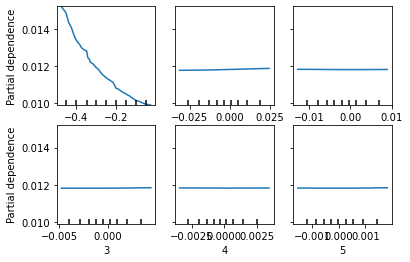

In [61]:
disp1 = PartialDependenceDisplay.from_estimator(best_random, dep,
...                                                 [0,1,2,3,4,5])

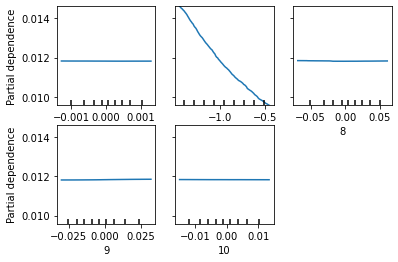

In [62]:
disp1 = PartialDependenceDisplay.from_estimator(best_random, dep,
...                                                 [6,7,8,9,10])

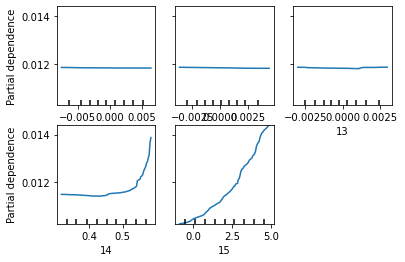

In [63]:
disp1 = PartialDependenceDisplay.from_estimator(m, dep,
...                                                 [11,12,13,14,15,])

In [65]:
X_subTr = np.loadtxt('D:\\bro\\Analysis\\mSANN\\cd\\XTr.dat')# (42039, 16) 
X_subV = np.loadtxt('D:\\bro\\Analysis\\mSANN\\cd\\XV.dat') # (10935, 16) 
y_subCdTr = (np.loadtxt('D:\\bro\\Analysis\\mSANN\\cd\\yTr.dat')).reshape((-1,1)) # (42039, 1) 
y_subCdV = (np.loadtxt('D:\\bro\\Analysis\\mSANN\\cd\\yV.dat')).reshape((-1,1)) # (10935, 1) 
dy_subCdTr = np.loadtxt('D:\\bro\\Analysis\\mSANN\\cd\\dyTr.dat') # (42039, 16) 
X_transTr = np.loadtxt('D:\\bro\\Analysis\\mSANN\\cd\\X_transTr.dat') # (4120, 10) 
X_transV = np.loadtxt('D:\\bro\\Analysis\\mSANN\\cd\\X_transV.dat') # (787, 10) 
y_transCdTr = (np.loadtxt('D:\\bro\\Analysis\\mSANN\\cd\\y_transCdTr.dat')).reshape((-1,1)) # (4120, 1) 
y_transCdV = (np.loadtxt('D:\\bro\\Analysis\\mSANN\\cd\\y_transV.dat')).reshape((-1,1)) # (787, 1) 
dy_transCdTr = np.loadtxt('D:\\bro\\Analysis\\mSANN\\cd\\dy_transCdTr.dat') # (4120, 10)
print(X_subTr.shape,X_subV.shape,y_subCdTr.shape,y_subCdV.shape,dy_subCdTr.shape,X_transTr.shape,X_transV.shape,y_transCdTr.shape,y_transCdV.shape,dy_transCdTr.shape)

(42039, 16) (10935, 16) (42039, 1) (10935, 1) (42039, 16) (4120, 10) (787, 10) (4120, 1) (787, 1) (4120, 10)


In [66]:
# Read dimensions of the data
nSubTr = X_subTr.shape[0] # 42039
nSubV = X_subV.shape[0] #  10935
dimSub = X_subV.shape[1] # 16
nTransTr = X_transTr.shape[0] # 4120
nTransV = X_transV.shape[0] # 787
dimTrans = X_transV.shape[1] # 10
print(nSubTr,nSubV,dimSub,nTransTr,nTransV,dimTrans)

42039 10935 16 4120 787 10


In [67]:
# Define the new design space
XTr = np.zeros((nTransTr+nSubTr,dimTrans + dimSub - 2))
print(XTr.shape)
XTr[:nTransTr,:dimTrans-2] = X_transTr[:,:dimTrans-2]
print(XTr.shape)
XTr[nTransTr:,dimTrans-2:] = X_subTr
print(XTr.shape)
XTr[:nTransTr,-2:] = X_transTr[:,-2:]
print(XTr.shape)
XV = np.zeros((nTransV+nSubV,dimTrans + dimSub - 2))
print(XV.shape)
XV[:nTransV,:dimTrans-2] = X_transV[:,:dimTrans-2]
print(XV.shape)
XV[nTransV:,dimTrans-2:] = X_subV
print(XV.shape)
XV[:nTransV,-2:] = X_transV[:,-2:]
print(XV.shape)
yTr = np.zeros((nSubTr+nTransTr,1))
print(yTr.shape)
yTr[:nTransTr,0] = y_transCdTr.T
print(yTr.shape)
yTr[nTransTr:,0] = y_subCdTr.T
print(yTr.shape)
yV = np.zeros((nSubV+nTransV,1))
print(yV.shape)
yV[:nTransV,0] = y_transCdV.T
print(yV.shape)
yV[nTransV:,0] = y_subCdV.T
print(yV.shape)
dyTr = np.zeros((nTransTr+nSubTr,dimTrans + dimSub - 2))
print(dyTr.shape)
dyTr[:nTransTr,:dimTrans-2] = dy_transCdTr[:,:dimTrans-2]
print(dyTr.shape)
dyTr[nTransTr:,dimTrans-2:] = dy_subCdTr
print(dyTr.shape)
dyTr[:nTransTr,-2:] = dy_transCdTr[:,-2:]
print(dyTr.shape)
dyV = np.zeros((nTransV+nSubV,dimTrans + dimSub - 2))
print(dyV.shape)


(46159, 24)
(46159, 24)
(46159, 24)
(46159, 24)
(11722, 24)
(11722, 24)
(11722, 24)
(11722, 24)
(46159, 1)
(46159, 1)
(46159, 1)
(11722, 1)
(11722, 1)
(11722, 1)
(46159, 24)
(46159, 24)
(46159, 24)
(46159, 24)
(11722, 24)


In [69]:
type(XTr)

numpy.ndarray

In [68]:
XTr

array([[-1.49592810e-01,  1.72453980e-02,  3.91858592e-04, ...,
         0.00000000e+00,  7.06098885e-01,  8.32776140e-01],
       [-2.69108594e-03,  2.09506121e-02, -4.88856133e-04, ...,
         0.00000000e+00,  7.38082194e-01,  1.40810324e+00],
       [-1.59063630e-02,  4.97942118e-03, -2.42853635e-04, ...,
         0.00000000e+00,  7.12908650e-01,  2.24503864e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.92323637e-04,  5.42336827e-01,  4.47327215e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         7.71995651e-04,  5.52554775e-01,  4.76813228e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -9.01567751e-04,  5.34594907e-01,  4.43451823e+00]])

In [11]:
# Set up NN parameters
INPUT_DIM = dimTrans+dimSub-2
OUTPUT_DIM = 1
NUM_SAMPLES =  int(XTr.shape[0]/3)
NUM_TRAINING = XTr.shape[0]
NUM_VALIDATING = XV.shape[0]
NUM_HIDDEN = 100
print(INPUT_DIM,OUTPUT_DIM,NUM_SAMPLES,NUM_TRAINING,NUM_VALIDATING,NUM_HIDDEN)

24 1 15386 46159 11722 100


In [12]:
class SobolevNetwork:
    def __init__(self, input_dim, num_hidden,init = None):
        self.input_dim = input_dim 
        self.num_hidden = num_hidden
        self.W1 = tf.Variable(tf.random_normal([self.input_dim, self.num_hidden],stddev=0.1))
        self.b1 = tf.Variable(tf.ones([self.num_hidden]))
        self.W2 = tf.Variable(tf.random_normal([self.num_hidden, self.num_hidden],stddev=0.1))
        self.b2 = tf.Variable(tf.ones([self.num_hidden]))
        self.W3 = tf.Variable(tf.random_normal([self.num_hidden, self.num_hidden],stddev=0.1))
        self.b3 = tf.Variable(tf.ones([self.num_hidden]))
        self.W4 = tf.Variable(tf.random_normal([self.num_hidden, self.num_hidden],stddev=0.1))
        self.b4 = tf.Variable(tf.ones([self.num_hidden]))
        self.W5 = tf.Variable(tf.random_normal([self.num_hidden, self.num_hidden],stddev=0.1))
        self.b5 = tf.Variable(tf.ones([self.num_hidden]))
        self.W6 = tf.Variable(tf.random_normal([self.num_hidden, self.num_hidden],stddev=0.1))
        self.b6 = tf.Variable(tf.ones([self.num_hidden]))        
        self.W7 = tf.Variable(tf.random_normal([self.num_hidden, 1],stddev=0.1))
        self.b7 = tf.Variable(tf.ones([1]))
        self.weights = [(self.W1, self.b1), (self.W2, self.b2), (self.W3, self.b3),(self.W4, self.b4), (self.W5, self.b5), (self.W6, self.b6),(self.W7, self.b7)]
        

    def forward(self, X):
        #Input layer
        out = X
        #Hidden layers
        W,b = self.weights[0]
        out = tf.nn.tanh(tf.matmul(out, W) + b)
        W,b = self.weights[1]
        out = tf.nn.tanh(tf.matmul(out, W) + b)
        W,b = self.weights[2]
        out = tf.nn.sigmoid(tf.matmul(out, W) + b)
        W,b = self.weights[3]
        out = tf.nn.sigmoid(tf.matmul(out, W) + b)
        W,b = self.weights[4]
        out = tf.nn.leaky_relu(tf.matmul(out, W) + b)
        W,b = self.weights[5]
        out = tf.nn.relu(tf.matmul(out, W) + b)
        #Output layer
        W,b = self.weights[-1]
        out = tf.matmul(out, W) + b
        return out

In [15]:
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


In [16]:
# Define tensors and operations
X = tf.placeholder(tf.float32, shape=[None, INPUT_DIM],name='X')
y = tf.placeholder(tf.float32, shape=[None,OUTPUT_DIM],name='y')
y_der = tf.placeholder(tf.float32, shape=[None, INPUT_DIM],name='dydX')
print(X.shape,y.shape,y_der.shape)

(?, 24) (?, 1) (?, 24)


In [18]:
model = SobolevNetwork(INPUT_DIM, NUM_HIDDEN) 
y_p = model.forward(X)
predict_named = tf.identity(y_p, "prediction")
dy = tf.gradients(y_p, X)
predict_named = tf.identity(dy, "gradient")
optimizer = tf.train.AdamOptimizer()
print(model,y_p)

<__main__.SobolevNetwork object at 0x000001FDB0C58B80> Tensor("add_6:0", shape=(?, 1), dtype=float32)


In [19]:
predict_named

<tf.Tensor 'gradient:0' shape=(1, ?, 24) dtype=float32>

In [20]:
dy

[<tf.Tensor 'gradients/MatMul_grad/MatMul:0' shape=(?, 24) dtype=float32>]

In [21]:
predict_named

<tf.Tensor 'gradient:0' shape=(1, ?, 24) dtype=float32>

In [22]:
optimizer

In [23]:
yLossLambda = dict()
for lam in range(11):
    yLossLambda[lam] = tf.reduce_mean(tf.pow(y_p - tf.reshape(y,[NUM_SAMPLES,1]), 2) + lam/10. * tf.reshape(tf.reduce_sum(tf.pow(dy - y_der, 2),2),[NUM_SAMPLES,1]))


In [24]:
yLossLambda

{0: <tf.Tensor 'Mean:0' shape=() dtype=float32>,
 1: <tf.Tensor 'Mean_1:0' shape=() dtype=float32>,
 2: <tf.Tensor 'Mean_2:0' shape=() dtype=float32>,
 3: <tf.Tensor 'Mean_3:0' shape=() dtype=float32>,
 4: <tf.Tensor 'Mean_4:0' shape=() dtype=float32>,
 5: <tf.Tensor 'Mean_5:0' shape=() dtype=float32>,
 6: <tf.Tensor 'Mean_6:0' shape=() dtype=float32>,
 7: <tf.Tensor 'Mean_7:0' shape=() dtype=float32>,
 8: <tf.Tensor 'Mean_8:0' shape=() dtype=float32>,
 9: <tf.Tensor 'Mean_9:0' shape=() dtype=float32>,
 10: <tf.Tensor 'Mean_10:0' shape=() dtype=float32>}

In [25]:
# Train storage
optim = dict()
timer = dict()
resTrain = dict()
for lam in range(11):
    optim[lam] = optimizer.minimize(yLossLambda[lam])
    timer[lam] = []
    resTrain[lam] = []

In [26]:
# Validation storage
resValid = []
resValid1 = []
resValid2 = []

# Saved model storage
saver = tf.train.Saver(max_to_keep=100)
errModel = np.zeros((1000,1000))

In [27]:
saver,errModel

(<tensorflow.python.training.saver.Saver at 0x1fdb4c0d4c0>,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [28]:
# Sobolev optimizer
tstart = time.time()
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [29]:
tstart,sess,init,sess

(1667414331.7105114,
 <tf.Operation 'init' type=NoOp>,
 <tensorflow.python.client.session.Session at 0x1fda3a1d0d0>)

In [30]:
X_valid = XV;y_valid = yV;dy_valid = dyV
valid_dict = {X: X_valid, y: y_valid, y_der: dy_valid}    
X_valid1 = XV[:nTransV,:];y_valid1 = yV[:nTransV,:];dy_valid1 = dyV[:nTransV,:]
valid_dict1 = {X: X_valid1, y: y_valid1, y_der: dy_valid1}
X_valid2 = XV[nTransV:,:];y_valid2 = yV[nTransV:,:];dy_valid2 = dyV[nTransV:,:]
valid_dict2 = {X: X_valid2, y: y_valid2, y_der: dy_valid2}
best_sub = 1000
best_trans = 1000
iter = 0

In [35]:
X_valid.shape

(11722, 24)

In [36]:
batch_samples = random.sample(range(NUM_TRAINING),NUM_SAMPLES)
X_train = XTr[batch_samples,:]
y_train = yTr[batch_samples,:]
dy_train = dyTr[batch_samples,:]
train_dict = {X: X_train, y: y_train, y_der: dy_train}

In [40]:
X_train.shape,y_train.shape,dy_train.shape

((15386, 24), (15386, 1), (15386, 24))